This notebook follows closely what Ahmed did and solves the Titanic Kaggle competition at https://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html

In [129]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
%matplotlib inline

# first get the data
test_data = pd.read_csv('C:/Users/JAY/Desktop/Machine_Learning_Course/KaggleCompetions/titanic_comp/data/test.csv')
train_data = pd.read_csv('C:/Users/JAY/Desktop/Machine_Learning_Course/KaggleCompetions/titanic_comp/data/train.csv')

train = train_data.copy()
test = test_data.copy()

Now we explore/visualize the data

In [130]:
# get the shape of the data
print(train.shape)
train.head()
print(test.shape)
test.head()

(891, 12)
(418, 11)


PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [131]:
train.describe()


PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

In [132]:
test.describe()

PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209    0.896760    0.981429   55.907576
min     892.000000    1.000000    0.170000    0.000000    0.000000    0.000000
25%     996.250000    1.000000   21.000000    0.000000    0.000000    7.895800
50%    1100.500000    3.000000   27.000000    0.000000    0.000000   14.454200
75%    1204.750000    3.000000   39.000000    1.000000    0.000000   31.500000
max    1309.000000    3.000000   76.000000    8.000000    9.000000  512.329200

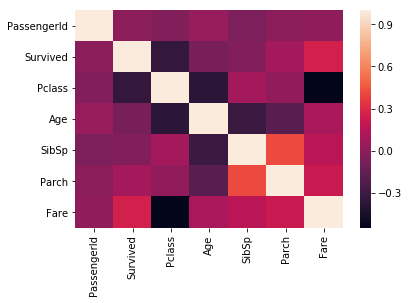

In [133]:
#check the feature correlation
corr = train.corr()
sns.heatmap(corr)

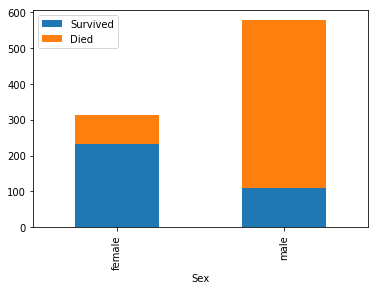

In [134]:
#check the affect of age on survival
train['Died'] = 1 - train['Survived']
train.groupby('Sex').agg('sum')[['Survived','Died']].plot(kind='bar', stacked=True )


In [135]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Died             int64
dtype: object

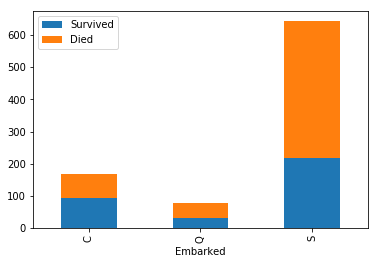

In [136]:
# compare survival rates for the sexes
train.groupby('Embarked').agg('sum')[['Survived','Died']].plot(stacked=True, kind='bar')

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64


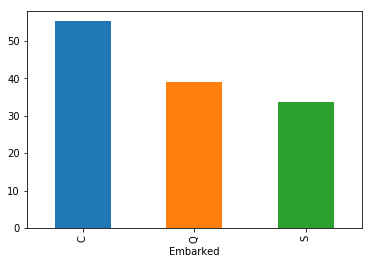

In [137]:
#compare survival rates for the embarcation
print(train.groupby(['Embarked'])['Survived'].sum()/train.groupby(['Embarked'])['Survived'].count())
embarked_survival_percent = train.groupby(['Embarked'])['Survived'].sum()/train.groupby(['Embarked'])['Survived'].count()*100
embarked_survival_percent.plot(kind='bar')

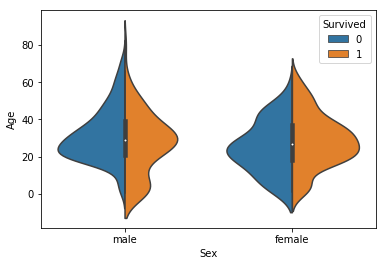

In [138]:
#correlate survival with age using a violin plot
# fig = plt.figure()
sns.violinplot(data=train, x='Sex', y='Age', hue='Survived', split=True)

Now start the Feature Engineering!

In [139]:
#make a function to combines the train and test data

def get_combined_data():
    test_data = pd.read_csv('C:/Users/JAY/Desktop/Machine_Learning_Course/KaggleCompetions/titanic_comp/data/test.csv')
    train_data = pd.read_csv('C:/Users/JAY/Desktop/Machine_Learning_Course/KaggleCompetions/titanic_comp/data/train.csv')

    train = train_data.copy()
    test = test_data.copy()
    
    targets = train.Survived
    train.drop(['Survived'], 1, inplace=True)
    
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index','PassengerId'], inplace=True, axis=1)
    
    return combined

   


In [140]:
combined = get_combined_data()
combined.shape
combined.head(30)

Pclass                                               Name     Sex   Age  \
0        3                            Braund, Mr. Owen Harris    male  22.0   
1        1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
2        3                             Heikkinen, Miss. Laina  female  26.0   
3        1       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
4        3                           Allen, Mr. William Henry    male  35.0   
5        3                                   Moran, Mr. James    male   NaN   
6        1                            McCarthy, Mr. Timothy J    male  54.0   
7        3                     Palsson, Master. Gosta Leonard    male   2.0   
8        3  Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)  female  27.0   
9        2                Nasser, Mrs. Nicholas (Adele Achem)  female  14.0   
10       3                    Sandstrom, Miss. Marguerite Rut  female   4.0   
11       1                           Bonnell, Miss. Elizabeth  female  58.0   
12       3                     Saundercock, Mr. William Henry    male  20.0   
13       3                        Andersson, Mr. Anders Johan    male  39.0   
14       3               Vestrom, Miss. Hulda Amanda Adolfina  female  14.0   
15       2                   Hewlett, Mrs. (Mary D Kingcome)   female  55.0   
16       3                               Rice, Master. Eugene    male   2.0   
17       2                       Williams, Mr. Charles Eugene    male   NaN   
18       3  Vander Planke, Mrs. Julius (Emelia Maria Vande...  female  31.0   
19       3                            Masselmani, Mrs. Fatima  female   NaN   
20       2                               Fynney, Mr. Joseph J    male  35.0   
21       2                              Beesley, Mr. Lawrence    male  34.0   
22       3                        McGowan, Miss. Anna "Annie"  female  15.0   
23       1                       Sloper, Mr. William Thompson    male  28.0   
24       3                      Palsson, Miss. Torborg Danira  female   8.0   
25       3  Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...  female  38.0   
26       3                            Emir, Mr. Farred Chehab    male   NaN   
27       1                     Fortune, Mr. Charles Alexander    male  19.0   
28       3                      O'Dwyer, Miss. Ellen "Nellie"  female   NaN   
29       3                                Todoroff, Mr. Lalio    male   NaN   

    SibSp  Parch            Ticket      Fare        Cabin Embarked  
0       1      0         A/5 21171    7.2500          NaN        S  
1       1      0          PC 17599   71.2833          C85        C  
2       0      0  STON/O2. 3101282    7.9250          NaN        S  
3       1      0            113803   53.1000         C123        S  
4       0      0            373450    8.0500          NaN        S  
5       0      0            330877    8.4583          NaN        Q  
6       0      0             17463   51.8625          E46        S  
7       3      1            349909   21.0750          NaN        S  
8       0      2            347742   11.1333          NaN        S  
9       1      0            237736   30.0708          NaN        C  
10      1      1           PP 9549   16.7000           G6        S  
11      0      0            113783   26.5500         C103        S  
12      0      0         A/5. 2151    8.0500          NaN        S  
13      1      5            347082   31.2750          NaN        S  
14      0      0            350406    7.8542          NaN        S  
15      0      0            248706   16.0000          NaN        S  
16      4      1            382652   29.1250          NaN        Q  
17      0      0            244373   13.0000          NaN        S  
18      1      0            345763   18.0000          NaN        S  
19      0      0              2649    7.2250          NaN        C  
20      0      0            239865   26.0000          NaN        S  
21      0      0            248698  

In [141]:
# engineer features based on name titles like Mr. Mrs. ect.

#get a list of all titles
#split the str at the ',' then take the second bit and split it at the period then take the first bit 
#then strip the spaces leftover  
# # make new feature for the titles
combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
combined.groupby('Title').count()

#check for missing titles *** there are none
combined.Title.isnull().sum()


0

In [142]:
# process the ages
combined.Age.describe()

train_temp = combined.iloc[:891].groupby(['Sex','Pclass','Title'])
train_temp_median = train_temp.median()
train_temp_median = train_temp_median.reset_index()[['Sex', 'Pclass','Title','Age']]
train_temp_median.head(30)

def fill_age(row):
    condition = (
        (train_temp_median['Sex'] == row['Sex']) & 
        (train_temp_median['Title'] == row['Title']) & 
        (train_temp_median['Pclass'] == row['Pclass'])
    ) 
    try:
        return train_temp_median[condition]['Age'].values[0]
    except:
        return train_temp_median.Age.median()
combined['Age'] = combined.apply(lambda row: fill_age(row) if np.isnan(row['Age']) else row['Age'], axis=1)
combined.isnull().sum()

# i could have also used the line :
# combined["Age"] = combined.groupby(['Sex','Pclass','Title'])['Age'].transform(lambda x: x.fillna(x.median()))
# which would do the same thing

Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin       1014
Embarked       2
Title          0
dtype: int64

In [143]:
# now process the titles feature 
# encode titles using one hot encoding for categories
title_encode = pd.get_dummies(combined.Title, prefix='Titles')
combined = pd.concat([combined, title_encode], axis='columns')
combined.drop('Title', axis='columns', inplace=True)
combined.drop('Name', axis='columns', inplace=True)



In [144]:
# encode the Fare value with the median value
combined.Fare.fillna(combined.iloc[:891].Fare.median(), inplace=True)

In [145]:
# process embark and one hot encode it
combined.Embarked.fillna(combined.Embarked.iloc[:891].mode(), inplace=True)
embarked_encode = pd.get_dummies(combined.Embarked, prefix='Embarked')
combined = pd.concat([combined, embarked_encode], axis='columns')
combined.drop('Embarked', axis='columns', inplace=True)

In [146]:
# process cabin feature
combined.Cabin.fillna('U', inplace=True)
combined.Cabin = combined.Cabin.apply(lambda x: x[0])
cabin = pd.get_dummies(combined.Cabin, prefix='Cabin')
combined = pd.concat([combined, cabin], axis=1)
combined.drop('Cabin', inplace=True, axis='columns')


In [147]:
# process Sex
combined.Sex = combined.Sex.map({'male':1, 'female':0})
combined.head()

Pclass  Sex   Age  SibSp  Parch            Ticket     Fare  Titles_Capt  \
0       3    1  22.0      1      0         A/5 21171   7.2500            0   
1       1    0  38.0      1      0          PC 17599  71.2833            0   
2       3    0  26.0      0      0  STON/O2. 3101282   7.9250            0   
3       1    0  35.0      1      0            113803  53.1000            0   
4       3    1  35.0      0      0            373450   8.0500            0   

   Titles_Col  Titles_Don   ...     Embarked_S  Cabin_A  Cabin_B  Cabin_C  \
0           0           0   ...              1        0        0        0   
1           0           0   ...              0        0        0        1   
2           0           0   ...              1        0        0        0   
3           0           0   ...              1        0        0        1   
4           0           0   ...              1        0        0        0   

   Cabin_D  Cabin_E  Cabin_F  Cabin_G  Cabin_T  Cabin_U  
0        0        0        0        0        0        1  
1        0        0        0        0        0        0  
2        0        0        0        0        0        1  
3        0        0        0        0        0        0  
4        0        0        0        0        0        1  

[5 rows x 37 columns]

In [148]:
# processing Pclass
pclass = pd.get_dummies(combined.Pclass, prefix='Pclass')
combined = pd.concat([combined, pclass], axis='columns')
combined.drop('Pclass', axis='columns', inplace=True)

In [149]:
# processing Ticket

# get the string preceding some ticket numbers
def clean_ticket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    tickt = ticket.split()
    ticket = map(lambda x: x.strip(), ticket)
    ticket = list(filter(lambda x: not x.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else:
        return 'xxx'
    
# get the set of unique ticket prefixes
tickets = set()
for t in combined.Ticket:
    tickets.add(clean_ticket(t))
    
# make a one hot feature based on the ticket prefixes
combined.Ticket = combined.Ticket.map(clean_ticket)
ticket_dummy = pd.get_dummies(combined.Ticket, prefix='Ticket')
combined = pd.concat([combined, ticket_dummy], axis='columns')
combined.drop('Ticket', axis='columns', inplace=True)



In [150]:
# process Family
combined['Family'] = combined.Parch + combined.SibSp
combined.Family = combined.Family.map(lambda x: 1 if x>0 else 0)

combined.drop(['Parch','SibSp'], inplace=True, axis='columns')
combined.Family.unique()


array([1, 0], dtype=int64)

Now its time to do the modelling. We will use 5 fold cross validation and use accuracy as the scoring metric.

In [151]:
# define a scoring function
def get_score(model, X, y, scoring='accuracy'):
    val = cross_val_score(model, X, y, cv=5, scoring=scoring)
    return np.mean(val)


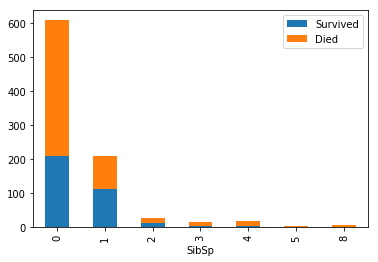

In [152]:
train.groupby('SibSp').agg('sum')[['Survived','Died']].plot(stacked=True, kind='bar')

In [153]:
def recover_train_test_target():
    global combined
    
    targets = pd.read_csv('./data/train.csv', usecols=['Survived'])['Survived'].values
    train = combined.iloc[:891]
    test = combined.iloc[891:]
    
    return train, test, targets

train, test, targets = recover_train_test_target()

We need to do some feature engineering to reduce the number of features

In [154]:
# get a model from the data
model = RandomForestClassifier(n_estimators=50, max_features='sqrt')
model = model.fit(train, targets)


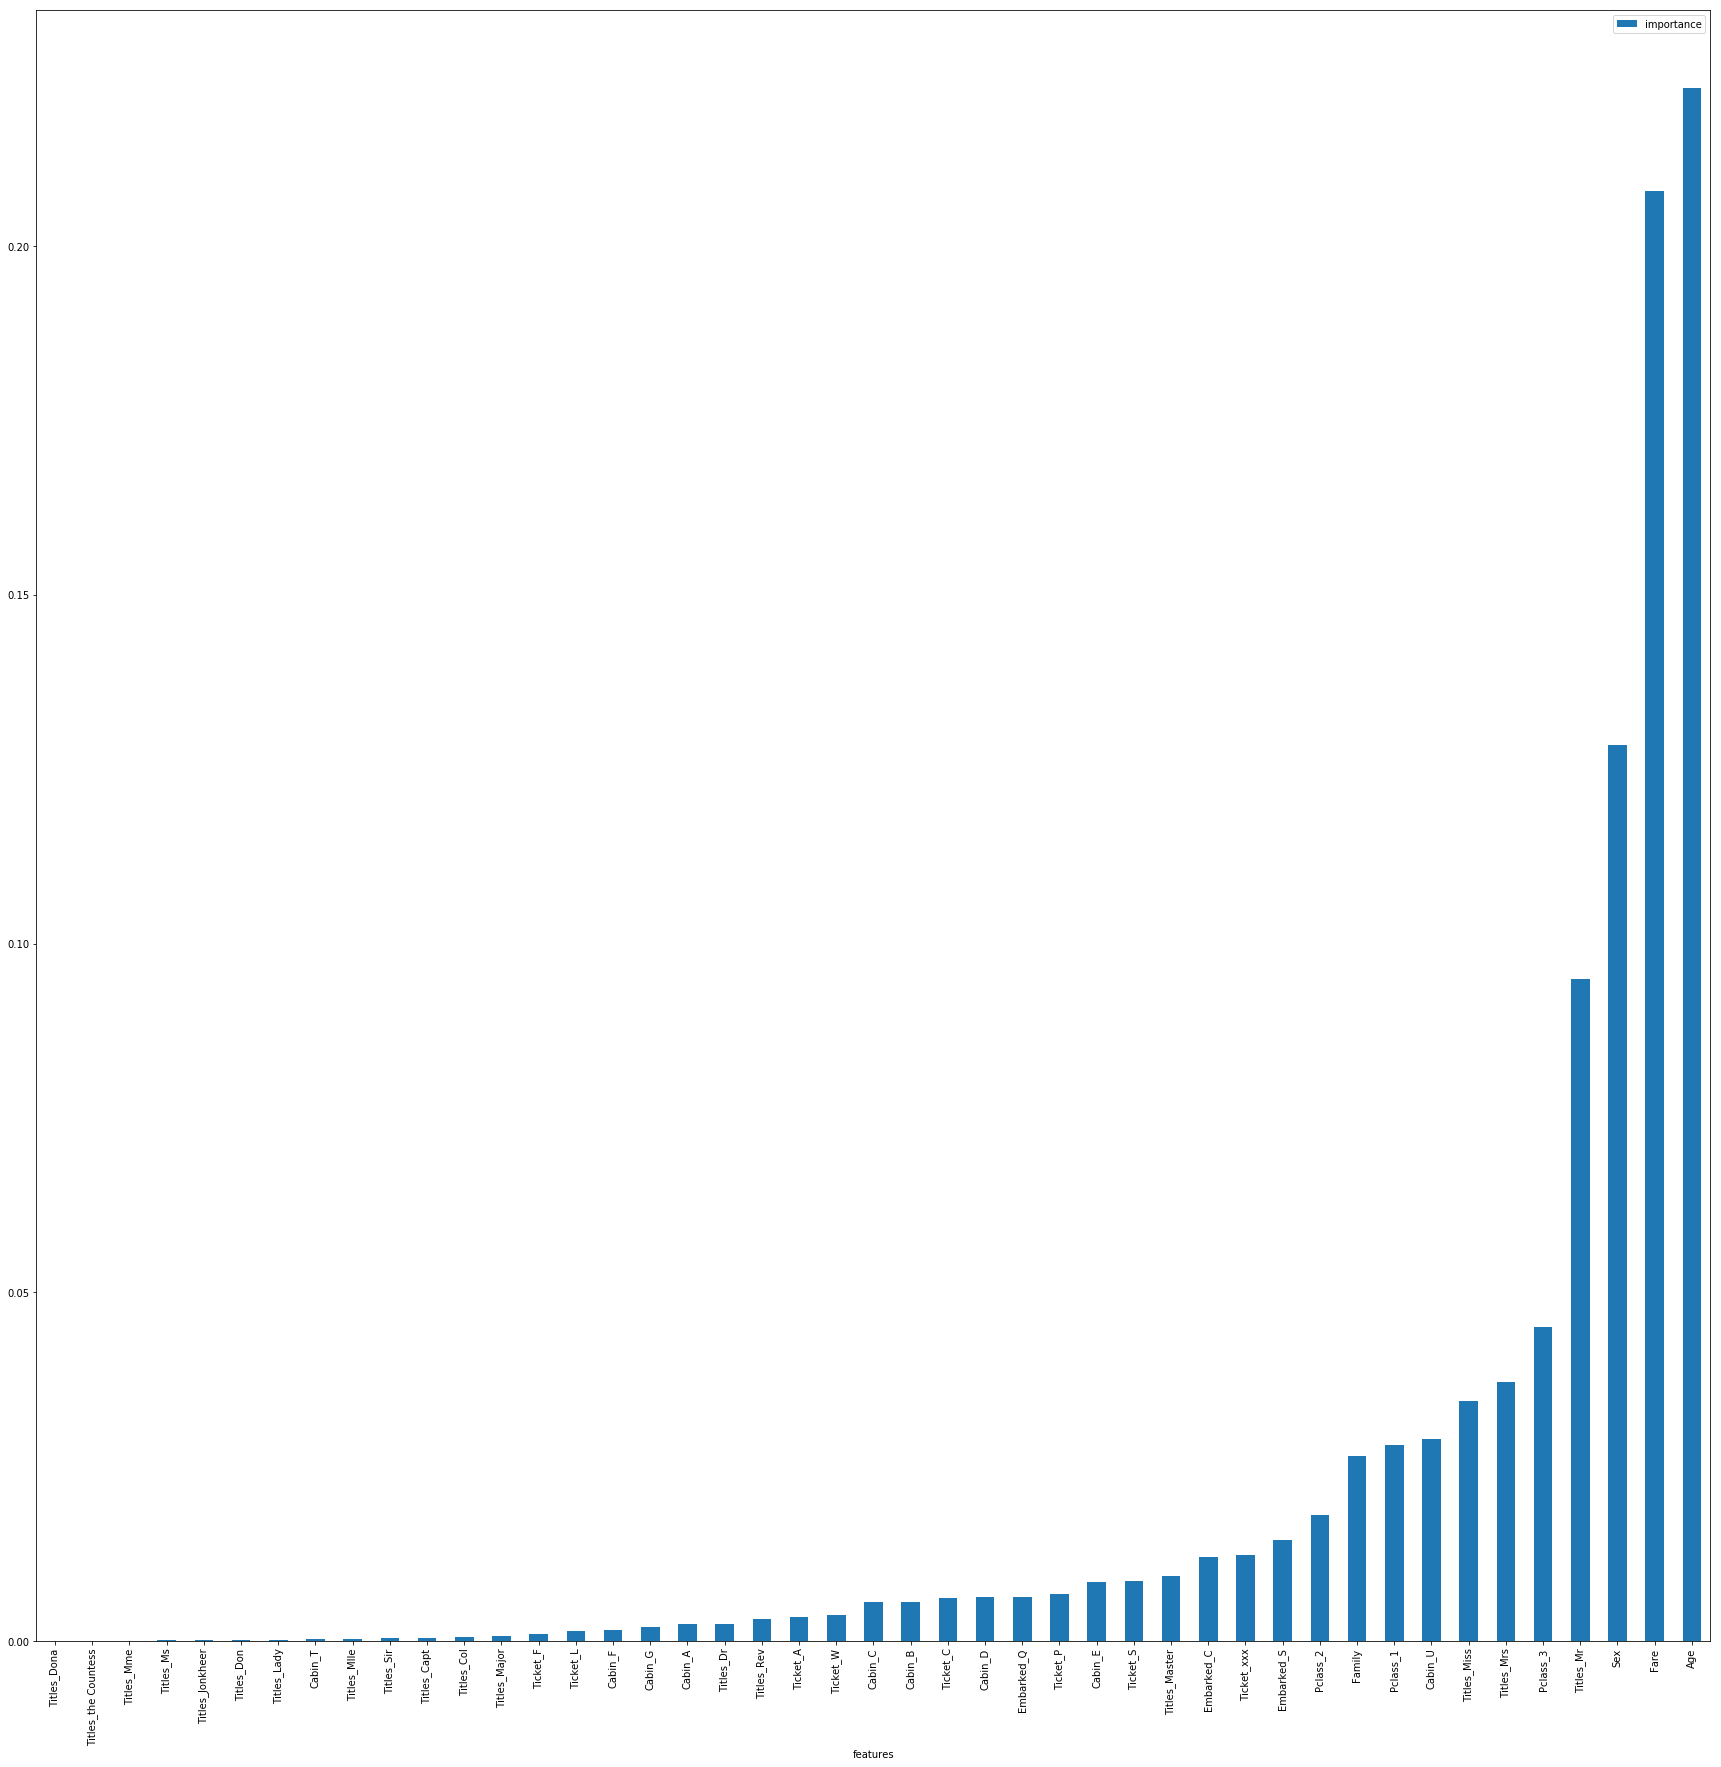

In [155]:
# look at the importance of each feature
features =  pd.DataFrame()
features['features'] = train.columns
features['importance'] = model.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('features', inplace=True)
features.plot(kind='bar', figsize=(30,30))

In [156]:
# now select the important features
model = SelectFromModel(model, prefit=True)
train_reduced = model.transform(train)
print(train_reduced.shape)


(891, 10)


In [157]:
test_reduced = model.transform(test)
print(test_reduced.shape)

(418, 10)


In [160]:
# try different models

logreg = LogisticRegression()
logreg_cv = LogisticRegressionCV()
rf = RandomForestClassifier()
gboost = GradientBoostingClassifier()

models_vec = [logreg, logreg_cv, rf, gboost]

for model in models_vec:
    print('Cross validation of : {0}'.format(model.__class__))
    score =  get_score(model=model, X=train_reduced, y=targets, scoring='accuracy')
    print('CV score: {0}'.format(score))
    print('****')
    


Cross validation of : <class 'sklearn.linear_model.logistic.LogisticRegression'>
CV score: 0.8013346752786645
****
Cross validation of : <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>
CV score: 0.8047117388653824
****
Cross validation of : <class 'sklearn.ensemble.forest.RandomForestClassifier'>
CV score: 0.820524174343665
****
Cross validation of : <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
CV score: 0.8238192813854381
****


Now do hyperparameter tuning with random forest

In [166]:
# turn run_gs to un grid search
run_gs = True
if run_gs:
    parameter_grid = {
        'max_depth': [4, 6, 8],
        'n_estimators': [50,10],
        'max_features': ['sqrt','auto','log2'],
        'min_samples_split': [2, 3, 10],
        'min_samples_leaf': [1, 3, 10],
        'bootstrap': [True, False]
    }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)
    grid_search = GridSearchCV(forest,
                                scoring='accuracy',
                                param_grid=parameter_grid,
                                cv=cross_validation,
                                verbose=1
                                
                              )
    grid_search.fit(train, targets)
    model = grid_search
    parameters = grid_search.best_params_
    
    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else:
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    model = RandomForestClassifier(**parameters)
    model.fit(train, targets)
    
    

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best score: 0.8305274971941639
Best parameters: {'bootstrap': False, 'max_depth': 6, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


[Parallel(n_jobs=1)]: Done 1620 out of 1620 | elapsed:  1.1min finished


In [172]:
# now generate an output file to submit
output = model.predict(test).astype(int)
df_output = pd.DataFrame()
aux = pd.read_csv('C:/Users/JAY/Desktop/Machine_Learning_Course/KaggleCompetions/titanic_comp/data/test.csv')
df_output['PassengerId'] = aux['PassengerId']
df_output['Survived'] = output
df_output[['PassengerId','Survived']].to_csv('C:/Users/JAY/Desktop/Machine_Learning_Course/KaggleCompetions/titanic_comp/submissions/gridsearch_rf.csv', index=False)

In [174]:
# bonus blending models
trained_models = []
for model in models_vec:
    model.fit(train, targets)
    trained_models.append(model)
    
predictions =[]
for model in trained_models:
    predictions.append(model.predict_proba(test)[:,1])
    

    
predictions_df = pd.DataFrame(predictions).T
predictions_df['out'] = predictions_df.mean(axis=1)
print(' Blended model score: ', )
predictions_df['PassengerId'] = aux['PassengerId']
predictions_df['out'] = predictions_df['out'].map(lambda s: 1 if s>0.5 else 0)

predictions_df = predictions_df[['PassengerId','out']]
predictions_df.columns = ['PassengerId','Survived']



 Blended model score: 


In [175]:
predictions_df.to_csv('C:/Users/JAY/Desktop/Machine_Learning_Course/KaggleCompetions/titanic_comp/submissions/blended_models.csv', index=False)
